In [3]:
import shutil
shutil.rmtree("nas_demo/mnist_nas")  # Delete previous tuner results

In [4]:
"""
Key Notes:

Search Space
------------
Number of hidden layers: 1–3
Units per layer: 32–256
Activation: relu or tanh
Learning rate: 1e-4 to 1e-2 (log scale)

Search Strategy
------------------
RandomSearch: randomly samples hyperparameters from the search space
Other options - Bayesian Optimization and Hyperband

Evaluation Strategy
--------------------
Uses validation split (validation_split=0.2) to evaluate each sampled model
Metric: val_accuracy is maximized
Each trial is trained for 5 epochs (can increase for better accuracy)
"""

'\nKey Notes:\n\nSearch Space\n------------\nNumber of hidden layers: 1–3\nUnits per layer: 32–256\nActivation: relu or tanh\nLearning rate: 1e-4 to 1e-2 (log scale)\n\nSearch Strategy\n------------------\nRandomSearch: randomly samples hyperparameters from the search space\nOther options - Bayesian Optimization and Hyperband\n\nEvaluation Strategy\n--------------------\nUses validation split (validation_split=0.2) to evaluate each sampled model\nMetric: val_accuracy is maximized\nEach trial is trained for 5 epochs (can increase for better accuracy)\n'

In [1]:
# Install dependencies if not already installed
# pip install tensorflow keras-tuner
#TensorFlow/Keras handles model creation and training
#KerasTuner adds an automated search layer that tunes hyperparameters or even model architectures
#It’s a lightweight and user-friendly tool for small-scale Neural Architecture Search (NAS)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

# =========================
# 1. Load and preprocess data (MNIST)
# =========================
# We’re using MNIST, a classic dataset of handwritten digits (0–9)
# This keeps the example simple while focusing on the NAS concept, not the dataset complexity
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Each image is 28×28 pixels Flatten to 1D vectors and normalize to [0,1]
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28*28).astype("float32") / 255.0

# =========================
# 2. Define the model-building function
# =========================
# This function defines the search space for NAS
def build_model(hp):
    """
    hp: HyperParameters object used by Keras Tuner to sample values
    """
    model = keras.Sequential()
    model.add(layers.Input(shape=(28*28,)))  # Input layer
    
    # -------------------------
    # Search Space
    # -------------------------
    # Tune number of hidden layers: 1 to 3
    # Neurons per layer: between 32 and 256, in steps of 32.
    # Activation function: choose between ReLU and tanh.
    for i in range(hp.Int("num_layers", 1, 3)):
        units = hp.Int(f"units_{i}", min_value=32, max_value=256, step=32)
        activation = hp.Choice("activation", ["relu", "tanh"])
        model.add(layers.Dense(units=units, activation=activation))
    
    # Output layer (fixed, 10 classes)
    model.add(layers.Dense(10, activation="softmax"))
    
    # -------------------------
    # Compile the model
    # -------------------------
    # Even the optimizer’s learning rate is tunable here
    # We’re using log sampling so KerasTuner tries both small and large learning rates efficiently
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# =========================
# 3. Define the search strategy
# =========================
#KerasTuner offers multiple search strategies — here we use Random Search for simplicity.
#Other options include Bayesian Optimization and Hyperband.
#The tuner manages the experiment setup — where to save results, how many trials to run, and what metric to optimize (in this case, validation accuracy).
tuner = kt.RandomSearch(
    build_model,                 # Model-building function
    objective="val_accuracy",    # Evaluation metric to maximize
    max_trials=5,                # Total number of different hyperparameter combinations to try
    executions_per_trial=1,      # Train each combination 1 time (for faster demo)
    directory="nas_demo",        # Folder to save tuner results
    project_name="mnist_nas"     # Name of this NAS project
)

# =========================
# 4. Run the search (NAS)
# =========================
# This is where NAS happens
tuner.search(x_train, y_train, epochs=5, validation_split=0.2)

# Evaluation strategy: Split 20% of training data for validation
# The tuner trains multiple models, each with different hyperparameters sampled from the search space
# Each model runs for 5 epochs — small but enough to demonstrate the concept
# After all trials, KerasTuner ranks them based on validation accuracy

# =========================
# 5. Retrieve the best model and hyperparameters
# =========================
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# After the search, we retrieve the best model and its hyperparameter configuration
# This gives us an architecture that performed best during tuning
# can then retrain it for more epochs or deploy it directly
# This is the key output of NAS, the optimal model design, found automatically

# =========================
# 6. Evaluate on test data
# =========================
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print("Best Hyperparameters:", best_hyperparameters.values)
print("Test Accuracy:", test_acc)

#The best model is evaluated on the test set to measure its generalization.


Reloading Tuner from nas_demo\mnist_nas\tuner0.json



C:\Users\bhalc\python\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9738 - loss: 0.0832
Best Hyperparameters: {'num_layers': 1, 'units_0': 256, 'activation': 'tanh', 'learning_rate': 0.000896642908951089}
Test Accuracy: 0.973800003528595


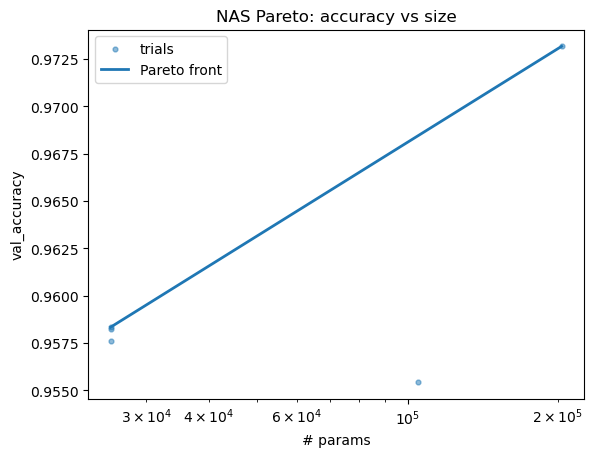

In [7]:
# collect trials
trials = tuner.oracle.get_best_trials(num_trials=50)

pts = []
for t in trials:
    hp = t.hyperparameters
    m = tuner.hypermodel.build(hp)
    acc = t.metrics.get_last_value("val_accuracy")
    pts.append((m.count_params(), acc))

# compute Pareto front (maximize acc, minimize params)
pts.sort(key=lambda x: x[0])  # sort by params
front = []
best_acc = -1.0
for p, a in pts:
    if a > best_acc:
        front.append((p, a))
        best_acc = a

import matplotlib.pyplot as plt
P, A = zip(*pts)
FP, FA = zip(*front)

plt.figure()
plt.scatter(P, A, s=12, alpha=0.5, label="trials")
plt.plot(FP, FA, linewidth=2, label="Pareto front")
plt.xscale("log")
plt.xlabel("# params")
plt.ylabel("val_accuracy")
plt.title("NAS Pareto: accuracy vs size")
plt.legend()
plt.show()

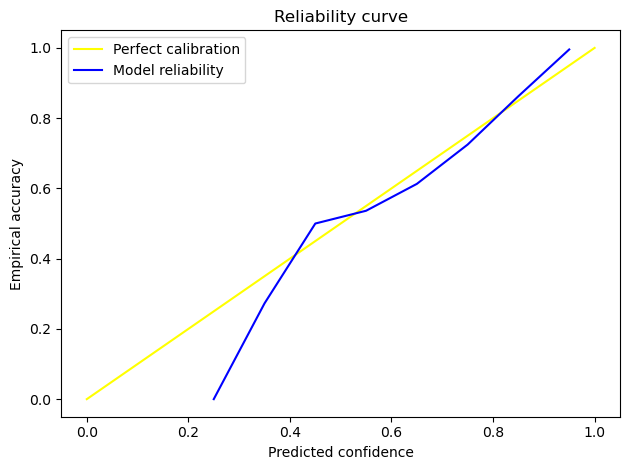

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Recompute predictions to avoid stale vars
probs = best_model.predict(x_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

conf = probs.max(axis=1)
correct = (y_pred == y_test).astype(int)

bins = np.linspace(0.0, 1.0, 11)
df = pd.DataFrame({"conf": conf, "correct": correct})
df["bin"] = pd.cut(df["conf"], bins, include_lowest=True)
calib = df.groupby("bin", observed=True)["correct"].agg(["mean", "count"]).reset_index()

centers = np.array([(b.left + b.right) / 2 for b in calib["bin"]])

plt.figure()
plt.plot([0, 1], [0, 1], label="Perfect calibration", color="yellow")
plt.plot(centers, calib["mean"], label="Model reliability", color="blue")
plt.xlabel("Predicted confidence")
plt.ylabel("Empirical accuracy")
plt.title("Reliability curve")
plt.legend()
plt.tight_layout()
plt.show()

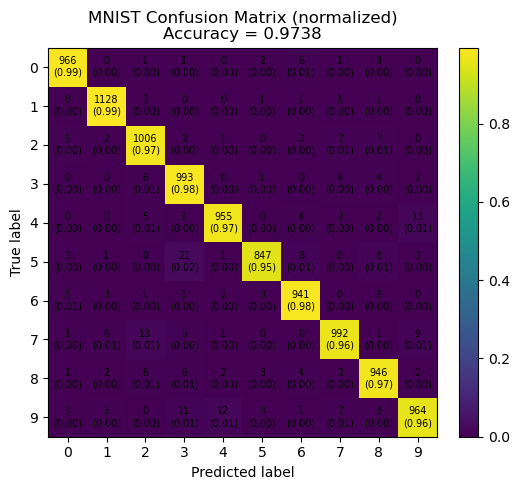

              precision    recall  f1-score   support

           0      0.982     0.986     0.984       980
           1      0.983     0.994     0.989      1135
           2      0.966     0.975     0.971      1032
           3      0.954     0.983     0.968      1010
           4      0.980     0.973     0.976       982
           5      0.985     0.950     0.967       892
           6      0.973     0.982     0.978       958
           7      0.976     0.965     0.971      1028
           8      0.968     0.971     0.970       974
           9      0.971     0.955     0.963      1009

    accuracy                          0.974     10000
   macro avg      0.974     0.973     0.974     10000
weighted avg      0.974     0.974     0.974     10000



In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

# Predict
y_prob = best_model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=range(10), zero_division=0)
report = classification_report(y_test, y_pred, digits=3)

# Confusion matrices
cm = confusion_matrix(y_test, y_pred, labels=range(10))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

classes = [str(i) for i in range(10)]

# Plot: normalized CM with counts and rates
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm_norm, interpolation="nearest")
ax.set_title(f"MNIST Confusion Matrix (normalized)\nAccuracy = {acc:.4f}")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks(range(10)); ax.set_yticks(range(10))
ax.set_xticklabels(classes); ax.set_yticklabels(classes)
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Annotate each cell with "count (rate)"
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        rate = cm_norm[i, j]
        ax.text(j, i, f"{cm[i,j]}\n({rate:.2f})",
                ha="center", va="center",
                fontsize=7)

plt.tight_layout()
plt.show()

"""
# Bar chart: per-class precision/recall/F1
x = np.arange(10)
width = 0.25
plt.figure(figsize=(7,3))
plt.bar(x - width, pr, width, label="Precision")
plt.bar(x,        rc, width, label="Recall")
plt.bar(x + width, f1, width, label="F1")
plt.xticks(x, classes)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Per-class Precision / Recall / F1")
plt.legend()
plt.tight_layout()
plt.show()
"""
# Text report
print(report)